In [7]:
ls ../data/bulk_RNAseq/

GSE130727_human_EC_Fibs/        GSE58910_human_astrocytes/  senMayo_data/
GSE171663_human_smooth_muscle/  GSE64553_human_fibs/


In [9]:
from pydeseq2.ds import DeseqStats
from pydeseq2.dds import DeseqDataSet
import senepy as sp
import pandas as pd
import os

from gseapy.plot import gseaplot
import gseapy as gp

import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [2]:
from sanbomics.tools import id_map

In [3]:
#function to turn gsea object into dataframe
def gsea_df(pre_res):
    out = []

    for term in list(pre_res.results):
        out.append([term,
                   pre_res.results[term]['fdr'],
                   pre_res.results[term]['es'],
                   pre_res.results[term]['nes']])

    out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
    out_df
    return out_df

In [4]:
#mouse markers
with open('../data/gene_lists/mouse_markers.txt') as f:
    mmarkers = list(f)
mmarkers = [x for x in mmarkers if not x.startswith('#') and ':' in x]
mmarkers = dict(map(lambda x: x.strip().split(':'), mmarkers)) #dict marker:role
mmarkers = list(mmarkers)

In [5]:
#human markers
with open('../data/gene_lists/human_markers.txt') as f:
    hmarkers = list(f)
hmarkers = [x for x in hmarkers if not x.startswith('#') and ':' in x]
hmarkers = dict(map(lambda x: x.strip().split(':'), hmarkers)) #dict marker:role
hmarkers = list(hmarkers)
hmarkers = [x.upper() for x in hmarkers]

In [6]:
#load gene sets for enrichment
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
senmayo_m = [x[0] + x[1:].lower() for x in senmayo]

with open('../data/gene_lists/senGPT.txt') as f:
    sengpt = [x.strip() for x in list(f)]
    sengpt_m = [x[0] + x[1:].lower() for x in sengpt]

In [7]:
####### testing signatures before updating senepy

# mouse_sets = {}

# m = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')
# for hub in m.hubs:
#     name = '.'.join([str(x) for x in hub])
#     mouse_sets[name] = [x[0] for x in m.hubs[hub]]
    
# mouse_sets['senMayo'] = senmayo_m
# mouse_sets['senGPT'] = sengpt_m
# mouse_sets['senMarkers'] = mmarkers

In [10]:
####### testing signatures before updating senepy

mouse_sets = {}


with open('../data/files/R1_TMS_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    m = pickle.load(handle)
    
m_meta = pd.read_pickle('../data/files/R1_TMS_SIGS_METADATA_FILTERED.pickle')


for hub in m:
    name = '.'.join([str(x) for x in hub])
    mouse_sets[name] = [x[0] for x in m[hub]]

mouse_sets['senMayo'] = senmayo_m
mouse_sets['senGPT'] = sengpt_m
mouse_sets['senMarkers'] = mmarkers

In [11]:

with open('../data/files/R1_6_HUMAN_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    h_signatures = pickle.load(handle)
    
h_metadata = pd.read_pickle('../data/files/R1_6_HUMAN_SIGS_METADATA_FILTERED.pickle')

In [12]:
human_sets = {}



####### testing signatures before updating senepy

# h = sp.load_hubs(species = 'Human', sig_type = 'cell_type')
# for hub in h.hubs:
#     name = '.'.join([str(x) for x in hub])
#     human_sets[name] = [x[0] for x in h.hubs[hub]]

for hub in h_signatures:
    name = '.'.join([str(x) for x in hub])
    human_sets[name] = [x[0] for x in h_signatures[hub]]

    
#######
    
human_sets['senMayo'] = senmayo
human_sets['senGPT'] = sengpt
human_sets['senMarkers'] = hmarkers

In [13]:
#function to filter out genes from a gene_set that were not in the background
def filter_gene_sets(gene_set, background_list):
    new_d = {}
    for entry in gene_set:
        filtered_genes = [x for x in gene_set[entry] if x in background_list]
        new_d[entry] = filtered_genes
        
    return new_d

# EC + fibs

In [ ]:
#4 cell types: WI-38, IMR-90, HUVEC, HAEC

#multiple induction
#RS, IR or doxorubicin, oncogene HRASG12V

In [14]:
paths = os.listdir('../data/bulk_RNAseq/GSE130727_human_EC_Fibs')

paths = ['../data/bulk_RNAseq/GSE130727_human_EC_Fibs/' + x for x in paths]

paths = [x for x in paths if not x.endswith('.tar')]


In [15]:
dater  = {
  "GSM3752521": "HAEC IR- 1",
  "GSM3752522": "HAEC IR- 2",
  "GSM3752523": "HAEC IR+ 1",
  "GSM3752524": "HAEC IR+ 2",
  "GSM3752525": "HAEC IR+ 3",
  "GSM3752526": "HUVEC IR- 1",
  "GSM3752527": "HUVEC IR- 2",
  "GSM3752528": "HUVEC IR- 3",
  "GSM3752529": "HUVEC IR+ 1",
  "GSM3752530": "HUVEC IR+ 2",
  "GSM3752531": "HUVEC IR+ 3",
  "GSM3752532": "IMR-90 PDL15 1",
  "GSM3752533": "IMR-90 PDL15 2",
  "GSM3752534": "IMR-90 IR+ 1",
  "GSM3752535": "IMR-90 IR+ 2",
  "GSM3752536": "IMR-90 PDL52 1",
  "GSM3752537": "IMR-90 PDL52 2",
  "GSM3752538": "WI-38 Dox- 1",
  "GSM3752539": "WI-38 Dox- 2",
  "GSM3752540": "WI-38 Dox+ 1",
  "GSM3752541": "WI-38 Dox+ 2",
  "GSM3752542": "WI-38 EV 1",
  "GSM3752543": "WI-38 EV 2",
  "GSM3752544": "WI-38 HRAS(G12v) 1",
  "GSM3752545": "WI-38 HRAS(G12v) 2",
  "GSM3752546": "WI-38 Dox- 3",
  "GSM3752547": "WI-38 Dox- 4",
  "GSM3752548": "WI-38 Dox+ 3",
  "GSM3752549": "WI-38 Dox+ 4",
  "GSM3752550": "WI-38 IR- 1",
  "GSM3752551": "WI-38 IR- 2",
  "GSM3752552": "WI-38 IR+ 1",
  "GSM3752553": "WI-38 IR+ 2",
  "GSM3752554": "WI-38 RS 1",
  "GSM3752555": "WI-38 RS 2",
  "GSM3752556": "WI-38 Control 1",
  "GSM3752557": "WI-38 Control 2"
}

In [16]:
counts = pd.DataFrame()

for file_path in paths:
    df = pd.read_csv(file_path, index_col="Tracking_ID", delimiter = '\t')
    
    gse = file_path.split('/')[-1].split('_')[0]
    
    df = df.rename(columns = {df.columns[0]: gse + '-' + df.columns[0]})
    
    
    if counts.empty:
        counts = df
    else:
        # If merged_data already has data, merge the loaded data with it using the index column
        counts = pd.merge(counts, df, on="Tracking_ID")
        
counts = counts[counts.sum(axis = 1) > 0]

In [17]:
counts

,GSM3752524-S04_COUNT,GSM3752537-S17_COUNT,GSM3752544-S24_COUNT,GSM3752526-S06_COUNT,GSM3752521-S01_COUNT,GSM3752530-S10_COUNT,GSM3752551-IR_Control_WCL_2_S10_S10_COUNT,GSM3752525-S05_COUNT,GSM3752536-S16_COUNT,GSM3752552-IR_Senescence_WCL_1_S11_S11_COUNT,...,GSM3752556-Young_Control_WCL_1_S1_S1_COUNT,GSM3752543-S23_COUNT,GSM3752546-DMSO_Control_WCL_1_S5_S5_COUNT,GSM3752532-S12_COUNT,GSM3752527-S07_COUNT,GSM3752553-IR_Senescence_WCL_2_S12_S12_COUNT,GSM3752538-S18_COUNT,GSM3752531-S11_COUNT,GSM3752540-S20_COUNT,GSM3752547-DMSO_Control_WCL_2_S6_S6_COUNT
Tracking_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,6929,4603,2291,6676,3584,7959,15010,8067,4381,28516,...,22398,1327,18244,4958,5907,38554,3356,7202,5005,21568
ENSG00000000005,6,2,0,2,3,4,0,17,7,0,...,0,0,12,8,2,0,0,14,4,9
ENSG00000000419,5446,5537,4337,7887,6037,5053,2953,6314,6010,5230,...,5892,1252,4667,4534,6708,6996,5651,4722,5468,5003
ENSG00000000457,2187,1779,1082,2574,2365,1877,3923,2552,2006,3315,...,5412,815,5293,2712,2256,2922,2138,1868,1342,6290
ENSG00000000460,2335,1411,598,4354,4109,2128,4245,2812,1419,2712,...,4165,667,3152,1551,3683,1868,2667,2281,681,4501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273487,2,11,2,0,0,2,0,0,6,35,...,36,4,24,10,0,2,1,0,2,40
ENSG00000273488,40,68,25,63,59,55,22,47,48,81,...,184,38,143,52,72,2,48,55,46,245
ENSG00000273489,2402,2710,1182,2114,2014,2160,1603,2845,2868,2171,...,4257,731,3258,3291,1931,1538,2096,1885,1641,3748


In [18]:
counts = counts.T

In [19]:
metadata = pd.DataFrame(counts.index, columns = ['Sample'])

metadata['GSE'] = metadata.Sample.str.split('-').str[0]


metadata['Cell'] = metadata.GSE.map(lambda x: dater[x].split()[0])
metadata['Treatment'] = metadata.GSE.map(lambda x: dater[x].split()[1])
metadata['Replicate'] = metadata.GSE.map(lambda x: dater[x].split()[2])


metadata = metadata.set_index('Sample')

metadata.head()

,GSE,Cell,Treatment,Replicate
Sample,,,,
GSM3752524-S04_COUNT,GSM3752524,HAEC,IR+,2
GSM3752537-S17_COUNT,GSM3752537,IMR-90,PDL52,2
GSM3752544-S24_COUNT,GSM3752544,WI-38,HRAS(G12v),1
GSM3752526-S06_COUNT,GSM3752526,HUVEC,IR-,1
GSM3752521-S01_COUNT,GSM3752521,HAEC,IR-,1


In [20]:
id_mapper = id_map(species = 'human')

def do_DE(cell, test1, test2):
    sub_meta = metadata[metadata.Cell == cell]
    
    sub_counts = counts[counts.index.isin(sub_meta.index)]
    
    sub_counts = sub_counts.T
    sub_counts = sub_counts[sub_counts.sum(axis = 1) > 0].T
    
    dds = DeseqDataSet(
    counts=sub_counts,
    metadata=sub_meta,
    design_factors="Treatment",
    refit_cooks=True,
    n_cpus=8,
    )
    
    dds.deseq2()
    
    
    stat_res = DeseqStats(dds, contrast=('Treatment', test1, test2))
    stat_res.summary()

    res = stat_res.results_df

    res = res.sort_values('stat', ascending = False)

    res['Symbol'] = res.index.map(id_mapper.mapper)

    res = res[res.baseMean > 10]
    
    return res
    

In [21]:
res = do_DE('HAEC', 'IR+', 'IR-')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.94 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/pydeseq2/dds.py:442: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 3.80 seconds.

Fitting LFCs...
... done in 2.97 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                    baseMean  log2FoldChange     lfcSE       stat  \
Tracking_ID                                                         
ENSG00000000003  5135.902976        0.724205  0.050270  14.406227   
ENSG00000000005     7.218367        2.704841  1.373627   1.969124   
ENSG00000000419  5287.906151       -0.319039  0.047182  -6.761883   
ENSG00000000457  2099.089751       -0.299135  0.069109  -4.328441   
ENSG00000000460  2946.577593       -0.967897  0.058662 -16.499504   
...                      ...             ...       ...        ...   
ENSG00000273487     1.086481        2.971062  3.758394   0.790514   
ENSG00000273488    48.836301       -0.818674  0.416027  -1.967840   
ENSG00000273489  2075.384619        0.131536  0.070873   1.855936   
ENSG00000273492    25.975629        0.373256  0.588027   0.634759   
ENSG00000273493     0.182640        0.416080  4.997838   0.083252   

                       pvalue          padj

In [22]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

rank = rank.set_index('Symbol', drop = True)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2024-11-04 16:13:01,446 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
2,heart.fibroblast,0.008790,0.520334,1.702969
3,hippocampus.endothelial cells,0.010488,0.574368,1.713126
4,senMarkers,0.010655,0.563107,1.760493
5,liver.macrophage,0.012986,0.615579,1.774358
6,blood.monocyte,0.013985,0.485812,1.637834
7,senGPT,0.022198,0.483698,1.536098
8,lung.type ii pneumocyte,0.022975,0.420574,1.546028
9,intestine.plasma cell,0.023610,0.491022,1.497642
10,blood.nk cell,0.023974,0.498989,1.789666
11,kidney.endothelial cell,0.024173,0.526222,1.505648


In [23]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

In [24]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res[(enr_res.Term.str.contains('endoth')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
37,gs_ind_0,senGPT,28/84,1.490423e-09,1.956610e-08,4.861322,98.802507,CXCL2;BMP4;CXCL6;ICAM1;GDF15;EDN1;HSPB1;IGFBP7...
38,gs_ind_0,senMarkers,23/74,1.830914e-07,1.121435e-06,4.388482,68.079759,CXCL2;IGFBP7;CXCL16;MMP11;CXCL1;IRF7;FOXO4;IGF...
16,gs_ind_0,hippocampus.endothelial cells,17/56,1.020636e-05,4.692602e-05,4.251463,48.859932,CORIN;GABARAP;EFNA1;EFEMP1;AKR1C1;IGFBP4;BCL2L...
39,gs_ind_0,senMayo,22/96,7.493111e-05,2.824326e-04,2.899987,27.546810,CXCL2;RPS6KA5;ICAM1;GDF15;IQGAP2;EDN1;IGFBP7;C...
41,gs_ind_0,skin.endothelial cell,29/154,2.579578e-04,7.435254e-04,2.258860,18.664318,TGM2;SGIP1;F8;ABI3BP;ACKR3;GLIPR2;TMOD2;CFD;CR...
30,gs_ind_0,lung.endothelial cell,17/81,1.360750e-03,3.333837e-03,2.600469,17.162368,SDC2;ADAM28;GPR155;CD37;ACAP1;SSPN;CDKN1C;SCAM...
23,gs_ind_0,kidney.endothelial cell,8/43,4.677541e-02,8.488872e-02,2.288581,7.008546,IGFBP3;ERF;GDF15;TIFA;CFH;HMOX1;NNMT;LIMS2
36,gs_ind_0,random_200,20/200,4.367112e-01,6.113956e-01,1.083961,0.898044,RNF180;KDM4B;MSTN;TNFSF10;MID2;AP003501.1;NRBP...
8,gs_ind_0,heart.endothelial cell,79/967,9.335071e-01,1.000000e+00,0.847800,0.058334,CRYZL1;GABARAP;DNAJB4;SOX4;RAB20;HRCT1;METTL7A...


### Sup Fig 6B

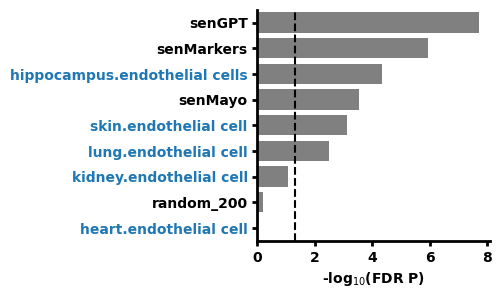

In [25]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/R1_S6B_real.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S6B_real.svg', bbox_inches = 'tight')

plt.show()

In [26]:
res = do_DE('HUVEC', 'IR+', 'IR-')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.05 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 3.97 seconds.

Fitting LFCs...
... done in 2.97 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.54 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                    baseMean  log2FoldChange     lfcSE       stat  \
Tracking_ID                                                         
ENSG00000000003  7227.243303        0.501590  0.040692  12.326521   
ENSG00000000005     8.505335        3.015880  1.028248   2.933029   
ENSG00000000419  6244.170638       -0.310438  0.039855  -7.789093   
ENSG00000000457  2169.347225       -0.179754  0.066274  -2.712276   
ENSG00000000460  3227.468889       -0.635238  0.062643 -10.140663   
...                      ...             ...       ...        ...   
ENSG00000273487     0.365192        2.072997  4.319529   0.479913   
ENSG00000273488    61.680091       -0.091249  0.314634  -0.290016   
ENSG00000273489  2122.548046        0.251032  0.063454   3.956147   
ENSG00000273492    12.464470        0.178665  0.800681   0.223141   
ENSG00000273493     0.346441        2.004471  4.325197   0.463440   

                       pvalue          padj

In [33]:
rank

,Rank,abs_rank
Symbol,,
PKHD1L1,44.661329,44.661329
DDIT4,40.002944,40.002944
ABI3BP,39.067045,39.067045
CFH,35.172626,35.172626
ZMAT3,34.338607,34.338607
...,...,...
H3C14,-34.528945,34.528945
H3C15,-34.610188,34.610188
TFPI2,-35.908451,35.908451


In [35]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]

rank = rank.set_index('Symbol')

user_set = filter_gene_sets(human_sets, rank.index.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2024-11-04 16:20:14,973 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,hippocampus.endothelial cells,0.000000,0.577385,1.921567
3,blood.nk cell,0.000000,0.470752,1.880969
4,blood.monocyte,0.000000,0.539340,1.994393
5,senMarkers,0.000000,0.562008,1.947331
6,lung.type ii pneumocyte,0.000000,0.458155,1.899608
9,heart.fibroblast,0.000482,0.505860,1.825896
10,senGPT,0.002480,0.478107,1.707188
11,skin.endothelial cell,0.002531,0.434752,1.704708
12,intestine.epithelial cell,0.003761,0.401487,1.657168
13,intestine.plasma cell,0.003857,0.490507,1.680321


In [36]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

In [39]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res[(enr_res.Term.str.contains('endoth')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
16,gs_ind_0,hippocampus.endothelial cells,14/56,0.000017,0.000137,4.698515,51.655015,CORIN;PLD1;EFEMP1;AKR1C1;ADM;BCL2L11;CEBPD;COL...
38,gs_ind_0,senMarkers,15/77,0.000188,0.001150,3.414360,29.296217,TIMP2;CDKN2A;VEGFB;CXCL11;CCL2;ANG;IRF7;MMP19;...
37,gs_ind_0,senGPT,12/84,0.011284,0.039355,2.368153,10.619667,TIMP2;BMP4;CDKN2A;CXCL6;ICAM1;GDF15;VCAM1;CCL2...
39,gs_ind_0,senMayo,12/96,0.029725,0.072826,2.030729,7.139575,TIMP2;IL32;CSF1;ICAM1;GDF15;ANG;CCL2;TNFRSF10C...
41,gs_ind_0,skin.endothelial cell,17/157,0.039143,0.089241,1.710854,5.544072,EFEMP2;CD36;SGIP1;ACKR4;PLTP;MEIS2;ABI3BP;MFAP...
30,gs_ind_0,lung.endothelial cell,8/87,0.240297,0.470982,1.464394,2.088050,ZFP14;RNASE6;ACAP1;CDKN1C;MS4A6A;SMPDL3B;CADM3...
23,gs_ind_0,kidney.endothelial cell,4/42,0.320358,0.603751,1.599867,1.821157,LIMS2;GDF15;CFH;PINK1
36,gs_ind_0,random_200,12/200,0.716345,0.995578,0.905985,0.302231,AP1G2;HOXA5;GSN;NECAB3;RWDD2A;ZNF251;ZSCAN23;B...
8,gs_ind_0,heart.endothelial cell,42/969,0.999641,1.000000,0.616357,0.000221,ZNF580;UBE2L6;FAM210B;PLK2;TPP1;CTSO;LGALS9;EF...


### Fig 6F

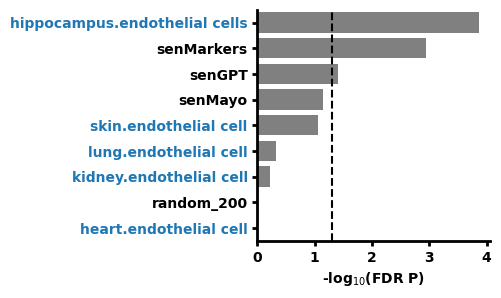

In [40]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/R1_6F.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_6F.svg', bbox_inches = 'tight')


plt.show()

In [41]:
res = do_DE('WI-38', 'IR+', 'IR-')

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 5.47 seconds.

Fitting dispersion trend curve...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 6.10 seconds.

Fitting LFCs...
... done in 5.68 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.16 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Tracking_ID                                                                   
ENSG00000000003  11620.442396        0.982857  0.466497  2.106888  0.035127   
ENSG00000000005      3.184950       -4.486466  3.424098 -1.310262  0.190107   
ENSG00000000419   5009.686769        0.874902  0.596006  1.467942  0.142120   
ENSG00000000457   2811.938484       -0.519870  0.235265 -2.209720  0.027125   
ENSG00000000460   2269.326872       -1.064043  0.470666 -2.260717  0.023777   
...                       ...             ...       ...       ...       ...   
ENSG00000273487     11.841823        2.276889  1.698024  1.340905  0.179951   
ENSG00000273488     88.114572       -0.540015  0.927125 -0.582462  0.560255   
ENSG00000273489   2260.144104       -0.012418  0.319352 -0.038886  0.968981   
ENSG00000273492      9.449322       -1.707261  1.479523 -1.153926  0.248

In [711]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2023-05-02 15:33:37,253 [WARNING] Duplicated values found in preranked stats: 0.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,senMayo,0.000000,0.679313,2.715059
1,heart.fibroblast,0.000000,0.616202,2.126785
2,senMarkers,0.000000,0.674192,2.547623
3,senGPT,0.000000,0.674639,2.563830
4,heart.neuronal cell,0.002127,0.485326,1.853790
5,blood.monocyte,0.004052,0.456322,1.795561
6,lung.type ii pneumocyte,0.004124,0.423916,1.767922
7,kidney.endothelial cell,0.004368,0.494354,1.755868
8,heart.myeloid cell,0.004862,0.635648,1.706557
9,blood.nk cell,0.005065,0.390683,1.714027


In [42]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res = enr_res[(enr_res.Term.str.contains('ibroblast')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
39,gs_ind_0,senMayo,38/109,1.386186e-21,6.792314e-20,9.930018,476.916241,CXCL2;PAPPA;PTGES;PLAU;ICAM1;SPP1;GDF15;CXCL8;...
38,gs_ind_0,senMarkers,31/85,1.597856e-18,3.914747e-17,10.608702,434.722014,CXCL2;PLAU;SERPINB2;CXCL5;CXCL8;CCL8;CXCL14;AR...
37,gs_ind_0,senGPT,27/85,1.367843e-14,2.234144e-13,8.600225,274.544618,CXCL2;STAT3;CCNE1;CXCL6;ICAM1;GDF15;CXCL5;CHEK...
9,gs_ind_0,heart.fibroblast,14/101,8.340943e-04,2.554414e-03,2.997980,21.253169,ATP6AP2;RNASE4;NDN;AKR1B1;TMEM100;IFI27;BST2;H...
31,gs_ind_0,lung.fibroblast,42/559,1.371822e-02,3.055421e-02,1.490661,6.393493,IGIP;AKR1C3;RNF180;ANKRA2;VWA5A;GHR;ACKR3;C16o...
36,gs_ind_0,random_200,11/200,4.864799e-01,6.621532e-01,1.090661,0.785886,SMPD1;MSR1;MFSD1;C4B-AS1;FAM3C;GRN;LINC00973;A...
42,gs_ind_0,skin.fibroblast,168/3530,9.357619e-01,1.000000e+00,0.885376,0.058784,PIGG;ALDH1A2;PLAU;PDPN;RNF180;LSAMP;CNTNAP1;PT...


### Fig 6G

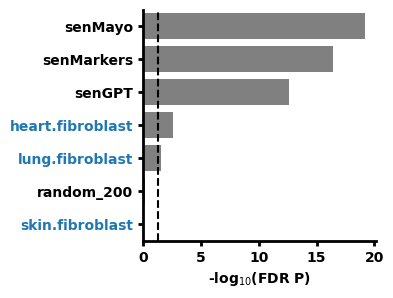

In [43]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/R1_6G.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_6G.svg', bbox_inches = 'tight')


plt.show()

In [44]:
res = do_DE('WI-38', 'Dox+', 'Dox-')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 5.54 seconds.

Fitting dispersion trend curve...
... done in 1.13 seconds.

Fitting MAP dispersions...
... done in 6.66 seconds.

Fitting LFCs...
... done in 5.41 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.40 seconds.



Log2 fold change & Wald test p-value: Treatment Dox+ vs Dox-
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Tracking_ID                                                                   
ENSG00000000003  11620.442396        0.554212  0.329955  1.679657  0.093024   
ENSG00000000005      3.184950        1.288690  1.771174  0.727591  0.466864   
ENSG00000000419   5009.686769        0.206610  0.421361  0.490339  0.623894   
ENSG00000000457   2811.938484       -0.196711  0.166580 -1.180878  0.237651   
ENSG00000000460   2269.326872       -0.745569  0.333024 -2.238785  0.025170   
...                       ...             ...       ...       ...       ...   
ENSG00000273487     11.841823        0.530713  1.174206  0.451976  0.651286   
ENSG00000273488     88.114572       -0.163597  0.649668 -0.251816  0.801183   
ENSG00000273489   2260.144104        0.045649  0.225514  0.202420  0.839588   
ENSG00000273492      9.449322       -0.275590  0.991846 -0.277855  0.7

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [ ]:
res = do_DE('WI-38', 'HRAS(G12v)', 'EV')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

In [45]:
res = do_DE('WI-38', 'RS', 'Control')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

# pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

# enr_res = gsea_df(pre_res)
# enr_res[enr_res.es > 0]

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 5.63 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 6.35 seconds.

Fitting LFCs...
... done in 5.47 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.20 seconds.



Log2 fold change & Wald test p-value: Treatment RS vs Control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Tracking_ID                                                                   
ENSG00000000003  11620.442396        0.070244  0.466507  0.150574  0.880311   
ENSG00000000005      3.184950        4.791935  3.407808  1.406163  0.159676   
ENSG00000000419   5009.686769       -0.108486  0.595922 -0.182047  0.855546   
ENSG00000000457   2811.938484       -0.374467  0.235095 -1.592833  0.111198   
ENSG00000000460   2269.326872       -0.525230  0.470673 -1.115911  0.264460   
...                       ...             ...       ...       ...       ...   
ENSG00000273487     11.841823       -0.407330  1.629255 -0.250010  0.802580   
ENSG00000273488     88.114572        0.100537  0.911838  0.110257  0.912206   
ENSG00000273489   2260.144104       -0.196752  0.318566 -0.617619  0.536826   
ENSG00000273492      9.449322       -1.651085  1.386686 -1.190670  0.

In [46]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res = enr_res[(enr_res.Term.str.contains('ibroblast')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
39,gs_ind_0,senMayo,26/109,2.228941e-14,1.092181e-12,8.432323,265.067258,ITGA2;CSF2;SCAMP4;PLAU;MMP10;BMP6;EDN1;AREG;CC...
37,gs_ind_0,senGPT,14/85,2.810251e-06,1.967176e-05,5.320529,68.008257,MMP3;IGFBP7;STAT1;BMP2;MMP10;MMP1;BMP6;VCAM1;E...
38,gs_ind_0,senMarkers,14/85,2.810251e-06,1.967176e-05,5.320529,68.008257,MMP3;IGFBP7;PLAU;MMP10;PLAT;CXCL11;CCL2;IRF1;S...
9,gs_ind_0,heart.fibroblast,8/101,3.437059e-02,6.736636e-02,2.367422,7.979524,AUP1;PPDPF;CLIC1;TMEM100;GRN;FIBIN;HLA-C;LGALS3BP
31,gs_ind_0,lung.fibroblast,26/559,1.422724e-01,2.248822e-01,1.295115,2.525490,TANGO2;MDGA1;AKR1C3;VWA5A;BTN2A1;ACKR3;TENM1;Z...
42,gs_ind_0,skin.fibroblast,135/3530,3.675263e-01,4.867240e-01,1.039476,1.040474,ALDH1A2;PLAU;ANKRD52;NCF2;TSC22D2;SLC6A6;ST8SI...
36,gs_ind_0,random_200,8/199,4.603591e-01,5.783999e-01,1.151190,0.893034,NOP10;TG;CIDECP1;CAMK2N2;MORC1;BAMBI;KIAA1671;...


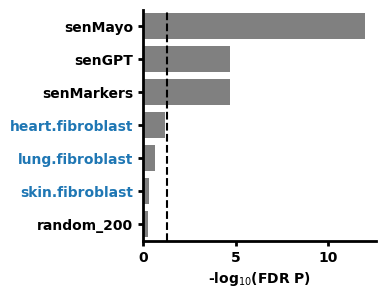

In [47]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/R1_6H.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_6H.svg', bbox_inches = 'tight')

plt.show()

# Mouse lung senolytic GSE180750 Fig 6E

In [48]:
#this study only put their sig DE genes up so getting background from something else
m_bacground = pd.read_csv('../data/bulk_RNAseq/senMayo_data/raw_gene_counts_INK_ATTAC.csv')['GeneName'].tolist()

In [49]:
ls ../data/bulk_RNAseq/GSE180750_mouse_lung_senolytic/

GSE180750_data3-sig_B_vs_C.xlsx  GSE180750_data3-sig_H_vs_C.xlsx
GSE180750_data3-sig_H_vs_B.xlsx


In [50]:
'''
vehicle treatment C
bleomycin instillation B
homoharringtonine administration H

'''

'\nvehicle treatment C\nbleomycin instillation B\nhomoharringtonine administration H\n\n'

In [51]:
res = pd.read_excel('../data/bulk_RNAseq/GSE180750_mouse_lung_senolytic/GSE180750_data3-sig_H_vs_B.xlsx')


res = res[['ProbeID', 'Gene_Symbol', 'H/B.fc', 'H/B.adj.pval']]

res.sort_values('H/B.fc', ascending = False)

,ProbeID,Gene_Symbol,H/B.fc,H/B.adj.pval
21,17284512,Ighv1-9,7.810600,0.000000e+00
79,17459324,Igkv1-117,6.120658,7.093972e-11
78,17459309,Igkv14-126,5.869198,1.235607e-07
18,17284349,Ighm,5.543204,1.049192e-11
49,17384374,Hc,4.645788,4.590217e-12
...,...,...,...,...
102,17503937,Mt2,-4.983203,2.371028e-09
40,17357640,Ms4a4a,-5.173916,1.678747e-13
33,17326075,Retnlg,-5.369694,1.842510e-11
32,17325324,Stfa2l1,-6.493442,3.385368e-23


In [56]:
user_set = mouse_sets.copy()
user_set['random_200'] = random.choices(m_bacground, k = 200)

#user_set = filter_gene_sets(mouse_sets, m_background)


enr = gp.enrichr(gene_list= res[res['H/B.fc'] < 0].Gene_Symbol.tolist(),
                 gene_sets= user_set,
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = m_bacground
                )

In [57]:
#if random200 doesn't have at least one value overlap it wont show up
[x for x in user_set['random_200'] if x in res[res['H/B.fc'] < 0].Gene_Symbol.tolist()]

['F13a1']

In [58]:
enr.results[enr.results.Term.str.startswith('ra')]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
39,gs_ind_0,random_200,1/200,0.256717,0.262829,5.093067,6.925462,F13a1


In [59]:
grapher = enr.results.sort_values('Adjusted P-value')

In [60]:
grapher = grapher[(grapher.Term.str.startswith('sen')) |\
        (grapher.Term.str.startswith('Lung')) |\
        (grapher.Term.str.startswith('Trachea')) |\
       (grapher.Term.str.startswith('random'))]


grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

In [61]:

grapher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,nlogp
27,gs_ind_0,Lung.fibroblast,15/753,2.560985e-13,1.101223e-11,18.009609,522.156444,C1qc;F13a1;Dpep2;Ccl2;Clec4e;Saa3;Cldn4;Pla1a;...,10.958125
37,gs_ind_0,Trachea.fibroblast,13/868,3.982661e-10,4.115866e-09,12.978869,280.913349,C1qc;Chl1;Serpina3m;Dpep2;Clec4e;C1qb;Saa3;Cld...,8.385539
38,gs_ind_0,Trachea.macrophage,13/1255,3.212329e-08,1.973288e-07,8.854709,152.776353,Fst;Serpina3n;Saa3;Cldn4;Adm;Pla1a;Cd109;Retnl...,6.704810
40,gs_ind_0,senGPT,5/93,2.835282e-07,1.354635e-06,45.042919,679.064980,Timp1;Col1a1;Ccl2;Serpine1;Lox,5.868178
26,gs_ind_0,Lung.alveolar macrophage,4/45,6.190614e-07,2.661964e-06,77.375983,1106.094435,AA467197;Stfa2l1;C1qc;Itgam,5.574798
42,gs_ind_0,senMayo,4/112,2.395974e-05,6.439179e-05,29.549492,314.381055,Ccl2;Spp1;Serpine1;Pappa,4.191170
36,gs_ind_0,Trachea.basal cell,5/337,1.454563e-04,3.474789e-04,11.921034,105.329901,C1qc;Serpina3n;Pla1a;Ms4a6d;Vsig4,3.459072
41,gs_ind_0,senMarkers,3/110,5.946686e-04,1.162307e-03,22.820079,169.496284,Timp1;Serpine1;Ccl2,2.934679
39,gs_ind_0,random_200,1/200,2.567167e-01,2.628290e-01,5.093067,6.925462,F13a1,0.580327


In [69]:
###OLD VERSION

grapher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,nlogp
28,gs_ind_0,Lung.fibroblast,14/755,4.597276e-12,1.011401e-10,16.446105,429.334743,Retnlg;Dpep2;Gda;Ms4a6d;Ccl2;C1qb;C1qc;Vsig4;C...,9.995077
38,gs_ind_0,Trachea.fibroblast,13/720,4.054091e-11,5.946000e-10,15.748719,376.846515,Dpep2;Ms4a6d;C1qb;AA467197;C1qc;Vsig4;Cldn4;It...,9.225775
39,gs_ind_0,Trachea.macrophage,15/1817,4.794436e-08,2.636940e-07,7.193855,121.239660,Retnlg;Lox;Serpina3n;Fst;Vsig4;Cldn4;Serpina3m...,6.578900
27,gs_ind_0,Lung.alveolar macrophage,6/154,1.164186e-07,5.691576e-07,32.221848,514.456397,Stfa2l1;AA467197;C1qc;Itgam;Il1r2;Cd177,6.244767
41,gs_ind_0,senGPT,5/93,2.835282e-07,1.247524e-06,45.042919,679.064980,Lox;Ccl2;Col1a1;Serpine1;Timp1,5.903951
43,gs_ind_0,senMayo,4/112,2.395974e-05,7.278046e-05,29.549492,314.381055,Ccl2;Spp1;Pappa;Serpine1,4.137985
42,gs_ind_0,senMarkers,3/110,5.946686e-04,1.308271e-03,22.820079,169.496284,Ccl2;Timp1;Serpine1,2.883302
37,gs_ind_0,Trachea.basal cell,5/551,1.350259e-03,2.475474e-03,7.216765,47.684481,Serpina3n;Ms4a6d;Vsig4;C1qc;Pla1a,2.606342
40,gs_ind_0,random_200,1/200,2.567167e-01,2.626869e-01,5.093067,6.925462,Cldn4,0.580562


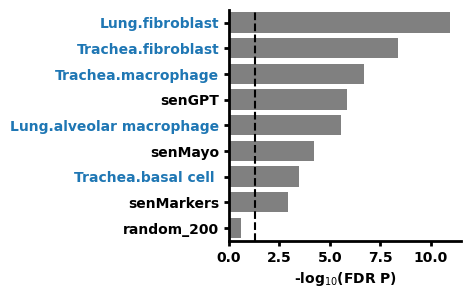

In [62]:
plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/R1_6E.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_6E.svg', bbox_inches = 'tight')


plt.show()

# Aged mouse muscle + sen GSE184348 Fig 6A

In [63]:
ls ../data/bulk_RNAseq/GSE184348_mouse_muscle_senolytic/

GSE184348_Muscle_RNAseq_raw_counts.xlsx


In [64]:
counts = pd.read_excel('../data/bulk_RNAseq/GSE184348_mouse_muscle_senolytic/GSE184348_Muscle_RNAseq_raw_counts.xlsx')

In [65]:
symbol_map = dict(zip(counts.GeneId, counts.GeneName))

In [66]:
counts = counts.drop(columns = 'GeneName').set_index('GeneId')

In [67]:
counts = counts[counts.sum(axis = 1) > 0]

In [68]:
m_background = counts.index.map(symbol_map).tolist() #symbol_background for enr

In [69]:
counts = counts.T
counts

GeneId,ENSMUSG00000051951,ENSMUSG00000089699,ENSMUSG00000103147,ENSMUSG00000103161,ENSMUSG00000102331,ENSMUSG00000025900,ENSMUSG00000104123,ENSMUSG00000025902,ENSMUSG00000104238,ENSMUSG00000102269,...,ENSMUSG00000101142,ENSMUSG00000075359,ENSMUSG00000099793,ENSMUSG00000096438,ENSMUSG00000099734,ENSMUSG00000095134,ENSMUSG00000095366,ENSMUSG00000096768,ENSMUSG00000099871,ENSMUSG00000096850
Muscle-Young-1,2,4,0,0,1,29,2,232,2,5,...,1,8,0,10,0,9,3,0,5,2
Muscle-Young-2,3,1,1,0,4,21,0,242,0,5,...,0,12,0,14,0,10,0,4,2,3
Muscle-Young-3,1,3,0,0,2,15,0,214,0,4,...,0,9,0,5,0,2,1,2,2,2
Muscle-Young-4,2,0,0,0,1,31,0,217,0,2,...,0,12,0,5,0,1,1,4,0,2
Muscle-Old-1,2,1,1,0,3,21,0,333,1,3,...,0,7,0,7,0,7,1,3,5,1
Muscle-Old-2,0,0,0,1,3,49,0,284,2,1,...,0,9,0,10,0,4,1,2,2,1
Muscle-Old-3,2,0,0,0,1,17,0,224,0,6,...,0,6,0,9,0,4,0,6,1,0
Muscle-Old-4,1,0,0,0,1,24,0,266,0,8,...,0,3,0,12,0,6,0,1,2,0
Muscle-DQ-1,1,0,0,0,7,16,0,212,1,5,...,0,6,1,11,0,5,1,9,5,1
Muscle-DQ-2,1,2,0,0,1,49,0,244,0,1,...,0,7,0,17,0,15,5,3,7,2


In [70]:
def smol_map(x):
    if 'Young' in x:
        return 'Young'
    elif 'Old' in x:
        return 'Old'
    else:
        return 'DQ'

metadata = pd.DataFrame(counts.index, columns = ['Sample'])

metadata['Treatment'] = metadata.Sample.map(smol_map)

metadata = metadata.set_index('Sample')

In [71]:
metadata

,Treatment
Sample,
Muscle-Young-1,Young
Muscle-Young-2,Young
Muscle-Young-3,Young
Muscle-Young-4,Young
Muscle-Old-1,Old
Muscle-Old-2,Old
Muscle-Old-3,Old
Muscle-Old-4,Old
Muscle-DQ-1,DQ


In [72]:

dds = DeseqDataSet(
counts=counts,
metadata=metadata,
design_factors="Treatment",
refit_cooks=True,
)

dds.deseq2()


stat_res = DeseqStats(dds,contrast=('Treatment', 'Old', 'DQ'))
stat_res.summary()

res = stat_res.results_df

res = res.sort_values('stat', ascending = False)

res['Symbol'] = res.index.map(symbol_map)

res = res[res.baseMean > 10]

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.68 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 1.42 seconds.

Fitting LFCs...
... done in 1.97 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: Treatment Old vs DQ
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneId                                                                       
ENSMUSG00000051951  1.498302       -0.051328  1.175106 -0.043679  0.965160   
ENSMUSG00000089699  1.149603       -1.769196  1.838655 -0.962223  0.335937   
ENSMUSG00000103147  0.139367        0.670110  4.127966  0.162334  0.871043   
ENSMUSG00000103161  0.075219        0.670112  4.127966  0.162335  0.871042   
ENSMUSG00000102331  2.362083       -0.791581  0.915504 -0.864640  0.387236   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000095134  5.660532       -0.492250  0.733316 -0.671266  0.502051   
ENSMUSG00000095366  1.168347       -1.888963  1.583150 -1.193168  0.232804   
ENSMUSG00000096768  3.131894       -0.345696  0.937020 -0.368931  0.712179   
ENSMUSG00000099871  3.047765       -1.028207  0.814743 -1.262002  0.206948   
ENSMUS

... done in 1.75 seconds.



In [73]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]

rank['Symbol'] = rank['Symbol'].astype(str)

user_set = filter_gene_sets(mouse_sets, rank.Symbol.values)

# pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

# enr_res = gsea_df(pre_res)
# enr_res[enr_res.es > 0]

In [79]:
user_set['random_200'] = random.choices(m_bacground, k = 200) #need at least one overlap or wont show up in df


enr = gp.enrichr(gene_list= res[(res['pvalue'] < 0.05) & (res.stat > 0)].Symbol.tolist(),
                 gene_sets= user_set,
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = m_bacground
                )

In [80]:
grapher = enr.results.sort_values('Adjusted P-value')

In [81]:
grapher = grapher[(grapher.Term.str.startswith('sen')) |\
        (grapher.Term.str.contains('myocyte')) |\
        (grapher.Term.str.startswith('Limb')) |\
       (grapher.Term.str.startswith('random'))]


grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

In [82]:

grapher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,nlogp
20,gs_ind_0,Limb_Muscle.macrophage,5/132,0.000344,0.001103,9.726715,77.583038,Ckap2;Clec14a;Gm14005;Rrm2;Tnfrsf23,2.957514
9,gs_ind_0,Heart_and_Aorta.myocyte,7/291,0.000377,0.001103,5.985302,47.190762,Dlg2;Aim2;Mx2;Agmat;Kctd7;Ttc9;Gm13154,2.957514
38,gs_ind_0,senGPT,4/74,0.000359,0.001103,14.336370,113.700459,Timp1;Edn1;Rb1;Cxcl1,2.957514
39,gs_ind_0,senMarkers,4/74,0.000359,0.001103,14.336370,113.700459,Timp1;Plau;Rb1;Cxcl1,2.957514
40,gs_ind_0,senMayo,3/82,0.006145,0.011997,9.834763,50.080446,Plau;Edn1;Cxcl1,1.920944
21,gs_ind_0,Limb_Muscle.smooth muscle cell,1/27,0.114827,0.130776,12.530097,27.119203,Rassf10,0.883473
37,gs_ind_0,random_200,1/199,0.593747,0.593747,1.666101,0.868541,Rap1gap2,0.226398


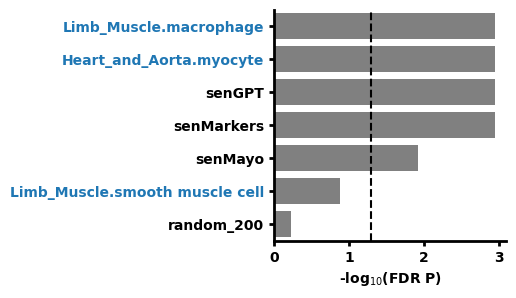

In [83]:
plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/R1_S6B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S6B.svg', bbox_inches = 'tight')

plt.show()